#Google Play Store Apps | Apps rating prediction

이 코드는 Kaggle에 있는 Google Play Store Apps의 데이터를 이용하여서 앱의 평점을 예측해보는 모델을 만드는 코드입니다.

본 코드에서 사용한 모델은 KNN과 랜덤 포레스트 모델입니다.

데이터 처리로 정수 인코딩 방식을 이용하였고, 몇몇 칼럼들은 데이터 프레임에서 제외하였습니다.

그럼 시작하겠습니다.

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/google_play_app_rating/googleplaystore.csv')

먼저 info를 이용하여 데이터를 확인해줍니다.

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


데이터셋은 10841개의 레코드와 13개의 칼럼들로 이루어져있습니다. <br>
Rating(평점)을 제외하고 나머지 데이터들은 모두 object type으로 되어있습니다.


데이터가 비어있는 칼럼
App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool


비어있는 데이터의 수
App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


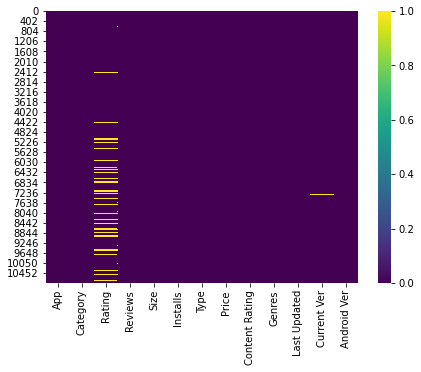

In [123]:
plt.figure(figsize=(7, 5))
sns.heatmap(df.isnull(), cmap='viridis')
print("데이터가 비어있는 칼럼")
print(df.isnull().any())
print("\n")
print("비어있는 데이터의 수")
print(df.isnull().sum())

분석을 통해서 Rating, Type, Content Rating, Current Ver, Android Ver에서 비어있는 데이터가 있음을 알 수 있습니다

값이 비어있는 데이터들은 오류를 일으키므로  제거해줍니다.

In [124]:
df.dropna(inplace = True)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
 10  Last Updated    9360 non-null   object 
 11  Current Ver     9360 non-null   object 
 12  Android Ver     9360 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


데이터가 비어있는 칼럼
App               False
Category          False
Rating            False
Reviews           False
Size              False
Installs          False
Type              False
Price             False
Content Rating    False
Genres            False
Last Updated      False
Current Ver       False
Android Ver       False
dtype: bool


비어있는 데이터의 수
App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64


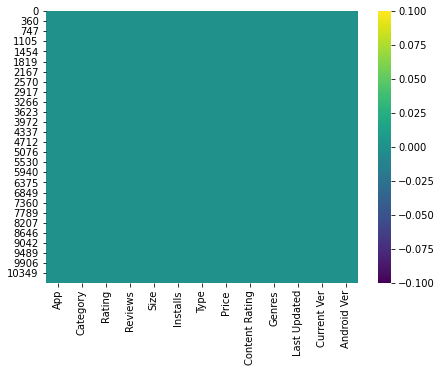

In [126]:
plt.figure(figsize=(7, 5))
sns.heatmap(df.isnull(), cmap='viridis')
print("데이터가 비어있는 칼럼")
print(df.isnull().any())
print("\n")
print("비어있는 데이터의 수")
print(df.isnull().sum())

이제 비어있는 값들이 없어졌습니다.

이제 다음은 텍스트로 되어있는 데이터들을 숫자로 바꾸는 절차입니다.

In [127]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


먼저 Category에 있는 텍스트들에 각각 번호를 부여 할 것입니다.

In [128]:
CategoryString = df["Category"]
categoryVal = df["Category"].unique()
categoryValCount = len(categoryVal)
category_dict = {}
for i in range(0,categoryValCount):
    category_dict[categoryVal[i]] = i
df["Category_c"] = df["Category"].map(category_dict).astype(int)

다음으로 Size에 있는 값들을 정리합니다.

SIze는 K값과 M값이 있는데 이를 숫자로 바꾸어 줄 것입니다.

K는 kb로 1000000을 곱하고 M는 mb로 1000을 곱합니다.

그리고 M이나 B가 없는 값들은 None을 리턴하고 이러한 값들은 fillna함수를 이용하여 값을 채워줍니다.

In [129]:
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

df["Size"] = df["Size"].map(change_size)

df.Size.fillna(method = 'ffill', inplace = True)

세번쨰로 Installs에 있는 , 를 제거합니다.

In [130]:
df['Installs'] = [int(i[:-1].replace(',','')) for i in df['Installs']]

네번쨰로 Type에 있는 Free 와 Paid를 이진수로 바꿉니다.

Free = 0 이며 Paid = 1입니다.

In [131]:
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

df['Type'] = df['Type'].map(type_cat)

다섯번째로 Content Rating입니다.

Content Rating은 콘텐츠 등급 즉 심의에 관련된 부분입니다.

Category에서 했던 방식과 동일한 방식을 적용합니다.

In [132]:
RatingL = df['Content Rating'].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
df['Content Rating'] = df['Content Rating'].map(RatingDict).astype(int)

여섯번쨰는 Genres입니다. 

위에 head부분의 1에서 볼수 있듯이 카테고리와 장르는 완전히 동일하지 않습니다. 

1	= ART_AND_DESIGN || Art & Design;Pretend Play

장르가 좀더 세부적인 정보를 가지고있습니다. 따라서 이를 구분해줍니다.

In [133]:
GenresL = df.Genres.unique()
GenresDict = {}
for i in range(len(GenresL)):
    GenresDict[GenresL[i]] = i
df['Genres_c'] = df['Genres'].map(GenresDict).astype(int)

일곱번째는 Prices의 값을 float으로 변경해줍니다.

In [134]:
def price_clean(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        price = float(price)
        return price

df['Price'] = df['Price'].map(price_clean).astype(float)

여덟번쨰로 Revies를 int로 변경해줍니다.

In [135]:
df['Reviews'] = df['Reviews'].astype(int)

마지막으로 필요하지 않는 데이터들을 제거합니다

Last Updated, Current Ver, Android Ver, App 이 4개의 칼럼들은 알고리즘에 적용하기에는 적절하지 못한 변수들이므로 제거합니다.

In [136]:
df.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        9360 non-null   object 
 1   Rating          9360 non-null   float64
 2   Reviews         9360 non-null   int64  
 3   Size            9360 non-null   float64
 4   Installs        9360 non-null   int64  
 5   Type            9360 non-null   int64  
 6   Price           9360 non-null   float64
 7   Content Rating  9360 non-null   int64  
 8   Genres          9360 non-null   object 
 9   Category_c      9360 non-null   int64  
 10  Genres_c        9360 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 877.5+ KB


In [138]:
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_c,Genres_c
0,ART_AND_DESIGN,4.1,159,19000000.0,10000,0,0.0,0,Art & Design,0,0
1,ART_AND_DESIGN,3.9,967,14000000.0,500000,0,0.0,0,Art & Design;Pretend Play,0,1
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000,0,0.0,0,Art & Design,0,0
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,0,0.0,1,Art & Design,0,0
4,ART_AND_DESIGN,4.3,967,2800000.0,100000,0,0.0,0,Art & Design;Creativity,0,2


info와 head 결과를 통해서 알 수 있듯이, 데이터셋 정리가 모두 끝났습니다.

이제 머신러닝을 할 차례입니다.

먼저 x와 y에 데이터 값들을 넣어줍니다. 이 후 학습 데이터와 실험 데이터를 분리합니다.

In [139]:
X = df.drop(labels = ['Category','Rating','Genres','Genres_c'],axis = 1)
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 10)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# K-Nearest Neighbors Model

첫번쨰로는 KNeighborsRegressor 모델 입니다.

In [140]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=15)
model.fit(X_train, y_train)
Results = model.predict(X_test)

In [141]:
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 1.4%'

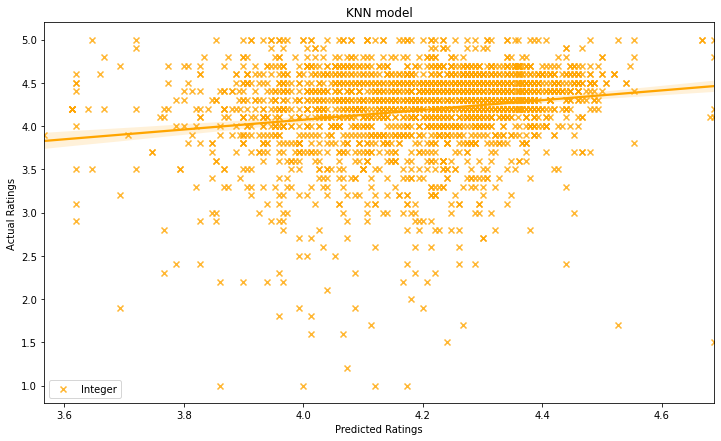

In [142]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='orange', label = 'Integer', marker = 'x')
plt.legend()
plt.title('KNN model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

[(10, -0.6582362170416751),
 (20, -0.32602492087635415),
 (30, -0.18887945935352746),
 (40, -0.14596389758937978),
 (50, -0.11463072749455261),
 (60, -0.058305409670832864),
 (70, -0.03699026536375305),
 (80, -0.012974408116291247),
 (90, -0.0037937987879796964),
 (100, 0.010590088995327651),
 (110, 0.017379609927775097),
 (120, 0.014330188278187439),
 (130, 0.015822675275595777),
 (140, 0.016092838609323534),
 (150, 0.014030942293771997),
 (160, 0.017027935213428158),
 (170, 0.02090781512763884),
 (180, 0.022322530482584813),
 (190, 0.02200963780925025)]

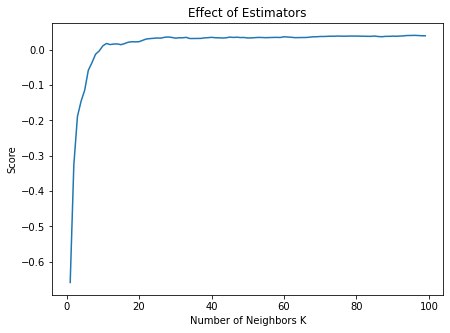

In [143]:
n_neighbors = np.arange(1, 100, 1)
#n_neighbors = np.arange(1, 200, 1)

scores = []
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    Results = model.predict(X_test)

plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)
results = list(zip(estimators,scores))
results

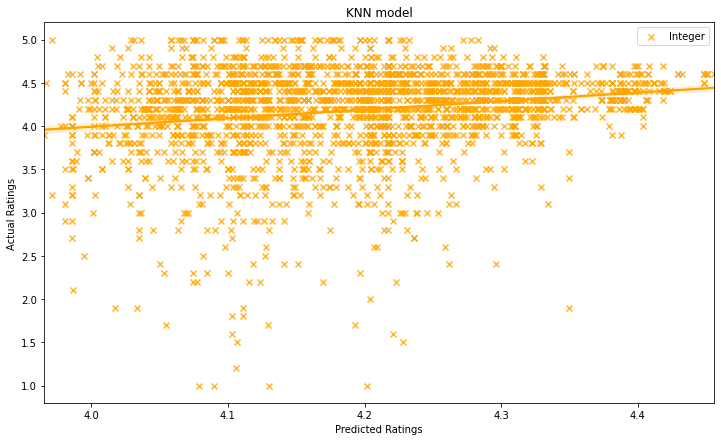

In [144]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='orange', label = 'Integer', marker = 'x')
plt.legend()
plt.title('KNN model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()


In [145]:
print ('Actual mean of population:' + str(y.mean()))
print ('Results mean :' + str(Results.mean()))
print ('Results std :' + str(Results.std()))

Actual mean of population:4.191837606837612
Results mean :4.19047138047138
Results std :0.10489374398380462


# Random Forest Model

다음은 RandomForestRegressor 모델 입니다.

In [146]:
X = df.drop(labels = ['Category','Rating','Genres','Genres_c'],axis = 1)
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 10)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


In [147]:
from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor()
model2.fit(X_train,y_train)
Results2 = model2.predict(X_test)


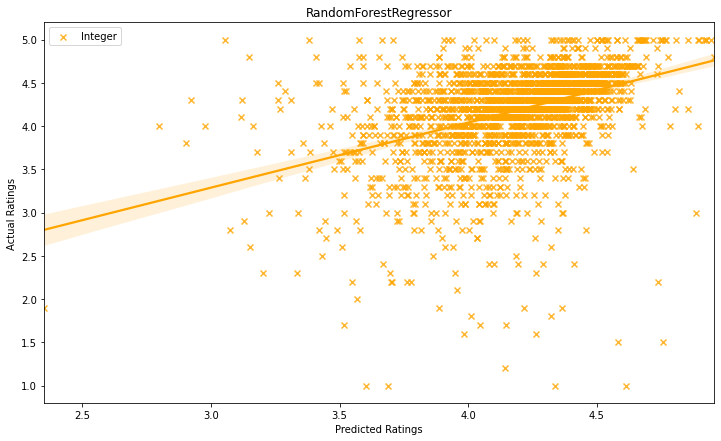

In [148]:
plt.figure(figsize=(12,7))
sns.regplot(Results2,y_test,color='orange', label = 'Integer', marker = 'x')
plt.legend()
plt.title('RandomForestRegressor')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()


In [149]:
accuracy = model2.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 14.9%'

[(10, 0.08006635601455192),
 (20, 0.11097908657503541),
 (30, 0.14976976356311955),
 (40, 0.14807920846866907),
 (50, 0.14272364218186862),
 (60, 0.1570528518208697),
 (70, 0.14897527481535),
 (80, 0.153868062130756),
 (90, 0.15765911213808015),
 (100, 0.14953804493534673),
 (110, 0.154592942860447),
 (120, 0.1588142254050109),
 (130, 0.15692267482746136),
 (140, 0.15957110972854327),
 (150, 0.15372897560643628),
 (160, 0.15496842452227588),
 (170, 0.16061543846416493),
 (180, 0.15930926914209953),
 (190, 0.16384594899885685)]

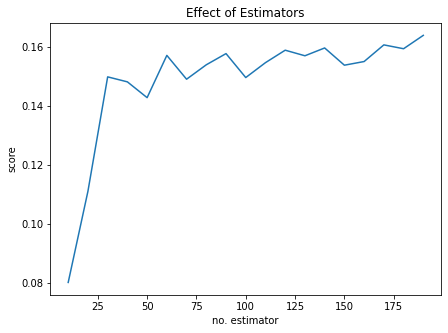

In [150]:
model2 = RandomForestRegressor()

#estimators = np.arange(10, 100, 10)
estimators = np.arange(10, 200, 10)

scores = []
for n in estimators:
    model2.set_params(n_estimators=n)
    model2.fit(X_train, y_train)
    scores.append(model2.score(X_test, y_test))
    Results = model2.predict(X_test)

plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results


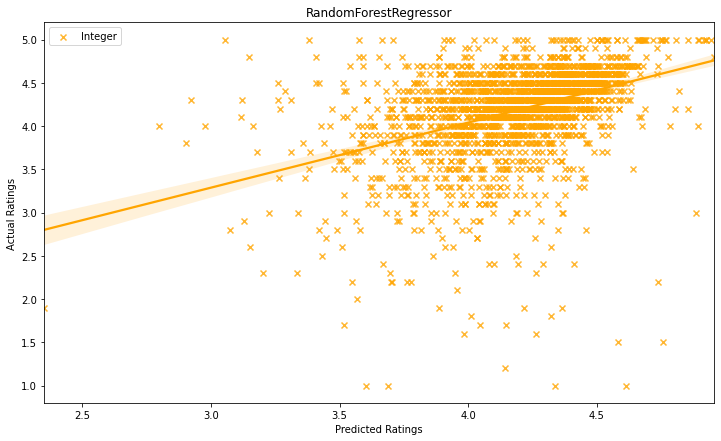

In [151]:
plt.figure(figsize=(12,7))
sns.regplot(Results2,y_test,color='orange', label = 'Integer', marker = 'x')
plt.legend()
plt.title('RandomForestRegressor')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [152]:
print ('Actual mean of population:' + str(y.mean()))
print ('Results mean :' + str(Results2.mean()))
print ('Results std :' + str(Results2.std()))

Actual mean of population:4.191837606837612
Results mean :4.1865442928367935
Results std :0.2829704733987761


# 결론

두 모델을 모두 적용해 보았을떄 정확도가 좋지 못했습니다.

여러가지 변수들을 조정하여 보았지만 정확도가 계속 좋아지지 않아서
데이터셋을 변경하기로 하였습니다.